# Autoencoder with PyTorch

**Denoising autoencoders**: We will evaluate denoising autoencoders applied to the MNIST dataset.

* Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a denoising autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set. You should use at least three layers in the encoder and in the decoder.
* We now need to determine how well this autoencoder works. For each image in the MNIST test dataset, compute the residual error of the autoencoder. This is the difference between the true image and the reconstruction of that image by the autoencoder. It is an image itself. Prepare a figure showing the mean residual error, and the first five principal components. Each is an image. You should preserve signs (i.e. the mean residual error may have negative as well as positive entries). The way to show these images most informatively is to use a mid gray value for zero, then darker values for more negative image values and lighter values for more positive values. The scale you choose matters. You should show
    * mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively and
    * mean and five principal components on a scale where the gray scale is chosen for each image separately.

**Variational autoencoders**: We will evaluate variational autoencoders applied to the MNIST dataset.
  * Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a variational autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set.
  * We now need to determine how well the codes produced by this autoencoder can be interpolated.
    * For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.
    * For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

**Hints and References**: For the denoising autoencoder, there is an abundance of code online should you choose to obtain one. It may be a good practice to also implement this part from scratch and test what you learned in the CNN assignment. All you have to do is define a network with two groups of layers:
  * *Encoder Layers*: This part must take an image and produce a low-dimensional "code" of the image. Therefore, the architecture of the netwok must be narrowing down. Let's call this function $f^{\text{encoder}}$.
  * *Decoder Layers*: This part must take a low-dimensional "code" of the image and produce the original image. Therefore, the architecture of the netwok must be expanding. Let's call this function $f^{\text{decoder}}$.
  
All you have to do is to try and write some code to minimize the following loss:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \|x_i - f^{\text{decoder}}(f^{\text{encoder}}(x_i))\|_2^2$$

You may pick any architecture that works as long as it has three layes. The MNIST data has 784 pixels. Therefore, a fully connected network which takes 784 reshaped dimensions to $h_1$ dimensions, then to $h_2$ dimensions, and finally to $h_3$ dimensions is an excellent starting point for an encoder. A vast range of choices can work for these three numbers, but just to give you an idea about their plausible range of values, $h_1$ could be in the order of hundreds, $h_2$ could be in order of tens (or at most a few hundreds), and $h_3$ is supposed to be a low-dimension (preferrably under 10 or at most 20).

You can reverse the encoder architecture, to obtain a decoder, and then stack an SGD optimizer on top with default hyper-parameters to train your denoising autoencoder. You must be familiar with the rest of the concepts from earlier assignments such as multi-dimensional scalings and PCA. You also would need to write some basic code to visualize using matplotlib, PIL, etc.

For VAEs, you may also be able to implement everything from scratch once you review the material. However, there are a lot of resources and examples for implementing VAEs, and here we share a few of them:

  1. Pytorch Tutorials has an example for training VAEs at https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
  2. Another pytorch example for VAEs can be found at https://github.com/pytorch/examples/blob/master/vae/main.py
  3. Pyro is a library for bayesian optimization and is based on pytorch, which has a detailed tutorial on how to train VAEs with some high-level story of the math involved https://pyro.ai/examples/vae.html
  4. BoTorch is another bayesian optimization library based based on pytorch and has some tutorials for implementing VAEs https://botorch.org/tutorials/vae_mnist
  5. If you're a tensorflow fan, you may find some tutorial at https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE or  https://www.tensorflow.org/tutorials/generative/cvae
  6. Keras fans can also see https://keras.io/examples/generative/vae/
  7. etc.
  
The MNIST data is provided at `./data_mnist` so that you could use the `torchvision` API for loading the data just like the previous assignment.

**Important Note**: This assignment will not be automatically graded and is optional. Therefore, do not expect meaninful grades to be published upon or after submission. However, please make sure to submit your work if you expect it to be reviewed by the instructors for any reason. We will consider the latest submission of your work. 

Any work that is not submitted will not be viewed by us.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import torch
import botorch
import pyro
import matplotlib.pyplot as plt
import tqdm

NameError: name 'trainloader' is not defined

## 1. Denoising Autoencoders

Code obtained from https://gist.github.com/bigsnarfdude/dde651f6e06f266b48bc3750ac730f80
and https://github.com/pranjaldatta/Denoising-Autoencoder-in-Pytorch/blob/master/DenoisingAutoencoder.ipynb

In [2]:
import os

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [3]:
if not os.path.exists('./denoise_samples'):
    os.mkdir('./denoise_samples')

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

num_epochs = 20
batch_size = 128
learning_rate = 1e-3

In [4]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img


def plot_sample_img(img, name):
    img = img.view(1, 28, 28)
    save_image(img, './sample_{}.png'.format(name))

In [5]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:tensor_round(tensor))
])

dataset = MNIST(root='./data_mnist', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

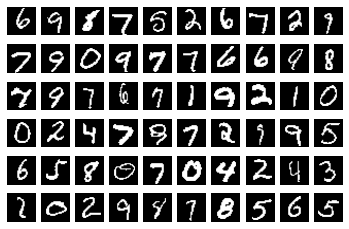

In [13]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#model = autoencoder().cuda()
model = autoencoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [9]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        noisy_img = add_noise(img)
        #noisy_img = Variable(noisy_img).cuda()
        noisy_img = Variable(noisy_img)
        #img = Variable(img).cuda()
        img = Variable(img)
        # ===================forward=====================
        output = model(noisy_img)
        loss = criterion(output, img)
        MSE_loss = nn.MSELoss()(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0], MSE_loss.data[0]))
    if epoch % 10 == 0:
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu().data)
        x_noisy = to_img(noisy_img.cpu().data)
        weights = to_img(model.encoder[0].weight.cpu().data)
        save_image(x, './mlp_img/x_{}.png'.format(epoch))
        save_image(x_hat, './mlp_img/x_hat_{}.png'.format(epoch))
        save_image(x_noisy, './mlp_img/x_noisy_{}.png'.format(epoch))
        save_image(weights, './filters/epoch_{}.png'.format(epoch))

#torch.save(model.state_dict(), './sim_autoencoder.pth')

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

## 2. Variational Autoencoders

Trying tutorial at https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'vae_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


In [10]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h) #using 3 layers
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h)) #using 4 layers
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 36417.4766, KL Div: 4509.7178
Epoch[1/15], Step [20/469], Reconst Loss: 29812.0371, KL Div: 1160.2372
Epoch[1/15], Step [30/469], Reconst Loss: 27277.1387, KL Div: 1326.3971
Epoch[1/15], Step [40/469], Reconst Loss: 26918.1504, KL Div: 725.4461
Epoch[1/15], Step [50/469], Reconst Loss: 26331.1719, KL Div: 801.4750
Epoch[1/15], Step [60/469], Reconst Loss: 25409.5820, KL Div: 990.8093
Epoch[1/15], Step [70/469], Reconst Loss: 25506.9648, KL Div: 1155.6455
Epoch[1/15], Step [80/469], Reconst Loss: 23618.4727, KL Div: 1256.1298
Epoch[1/15], Step [90/469], Reconst Loss: 22275.3672, KL Div: 1330.8800
Epoch[1/15], Step [100/469], Reconst Loss: 22062.6914, KL Div: 1320.1382
Epoch[1/15], Step [110/469], Reconst Loss: 21641.8906, KL Div: 1533.4253
Epoch[1/15], Step [120/469], Reconst Loss: 20719.7363, KL Div: 1715.8657
Epoch[1/15], Step [130/469], Reconst Loss: 19585.0664, KL Div: 1759.7727
Epoch[1/15], Step [140/469], Reconst Loss: 18805.3789, KL Div: 

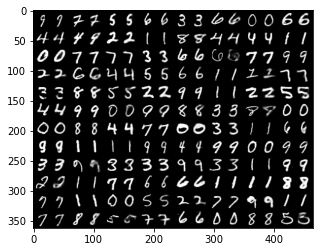

In [14]:
img_r = mpimg.imread('./samples/reconst-15.png')
plt.imshow(img_r)